In [1]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
from scipy.stats import pearsonr


sys.path.append(str(Path("../../..").resolve()))

from src.constants import processed_data_dir

In [6]:
df = pd.read_csv(processed_data_dir / "df_model_value.csv")

## Explore ACF

In [4]:
auto_cor = [{"lag": lag, "corr": df["value_1d_fwd_rel_ret"].autocorr(lag)} for lag in range(1, 90)]
pd.DataFrame(auto_cor).sort_values("corr", ascending=False).head()

,lag,corr
0,1,0.065141
26,27,0.062787
38,39,0.053305
84,85,0.039200
58,59,0.038751


In [180]:
def cross_corr(df, target, col, lag):
    if col not in ["Date", "value_1d_fwd_rel_ret"]:
        try:
            return pearsonr(df[target][lag:], df[col].shift(lag)[lag:])[0]
        except:
            return np.nan
    
    return np.nan
            
def cross_corrs(df = df, target = "value_1d_fwd_rel_ret", lag = 1):
    corr_dict= {}
    for col in df.columns.tolist():
        corr_dict[col] = cross_corr(df, target, col, lag)
    return corr_dict

In [196]:
corrs = pd.DataFrame([cross_corrs(df, "value_1d_fwd_rel_ret", lag) 
                            for lag in range(1, 91)])
corrs

/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4085: RuntimeWarning: invalid value encountered in subtract
  ym = y.astype(dtype) - ymean
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


,Date,S&P 500,MSCI DM,MSCI EM,WTI Crude Oil,S&P GSCI,Gold,Global Inflation-linked debt,iTraxx Europe 5Yr,iTraxx Crossover 5Yr,...,S&P 500 Price-to-Earnings,P/B,US Value P/E over Growth P/E,US Value P/B over Growth P/B,EquityBond premia,S&P 500 Skew,EURUSD Risk Reversal,USDJPY Risk Reversal,EURJPY Risk Reversal,value_1d_fwd_rel_ret
0,NaN,0.022576,0.034583,0.041494,0.013836,0.002398,0.012211,0.012737,-0.004117,-0.004924,...,0.016094,0.013175,0.007849,0.004061,-0.000159,0.003077,NaN,NaN,NaN,NaN
1,NaN,0.020316,0.013269,0.009952,0.025448,0.018139,-0.005035,0.008190,-0.012967,-0.014129,...,0.004888,-0.010189,-0.021988,-0.026903,-0.030004,0.002396,NaN,NaN,NaN,NaN
2,NaN,0.009635,0.008995,0.027271,0.015663,0.015874,-0.002112,0.016918,-0.004872,-0.003486,...,0.012385,0.008641,0.003983,0.000776,-0.003016,0.001559,NaN,NaN,NaN,NaN
3,NaN,0.011487,0.007355,0.012676,0.002963,-0.000853,0.004703,-0.005491,-0.002101,-0.003764,...,-0.002178,-0.002007,-0.001296,-0.000988,-0.001152,-0.001883,NaN,NaN,NaN,NaN
4,NaN,-0.002608,0.003980,-0.001386,-0.010528,-0.016211,-0.013287,-0.021068,-0.000232,-0.000737,...,-0.006077,-0.004183,-0.000809,0.000796,0.001978,-0.011177,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NaN,0.021000,0.015477,-0.001041,-0.006162,-0.005645,0.009519,0.029220,-0.009485,-0.007760,...,-0.006865,-0.013359,-0.016867,-0.017552,-0.016230,-0.014026,NaN,NaN,NaN,NaN
86,NaN,-0.015466,-0.022081,-0.032739,0.005344,-0.008219,0.026308,-0.001703,-0.003080,-0.002914,...,0.000403,-0.003930,-0.006566,-0.007679,-0.006322,0.003282,NaN,NaN,NaN,NaN
87,NaN,0.008734,0.007241,0.017218,-0.002824,-0.002224,0.013186,0.031165,0.011314,0.011444,...,0.031734,0.036028,0.031742,0.027028,0.019034,0.007243,NaN,NaN,NaN,NaN
88,NaN,-0.035126,-0.017825,0.008342,-0.009018,-0.022205,-0.023414,-0.014790,0.000696,0.001193,...,0.007717,0.013769,0.017101,0.017122,0.016434,0.001489,NaN,NaN,NaN,NaN


## Feature selection

## Prophet

In [37]:
from fbprophet import Prophet
m = Prophet( weekly_seasonality=True, yearly_seasonality=True)

In [38]:
df_model = df.rename(columns={"Date": "ds", "value_1d_fwd_rel_ret": "y"})

In [39]:

m.fit(df_model)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -91.1354


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       7869.12   0.000216302       120.047   1.892e-06       0.001      157  LS failed, Hessian reset 
      99       7869.18   1.94722e-05       72.5417      0.1219      0.1219      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136        7869.2   1.89829e-05       83.7063   2.182e-07       0.001      265  LS failed, Hessian reset 
     150        7869.2   2.51336e-07       67.7683      0.4097      0.4097      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


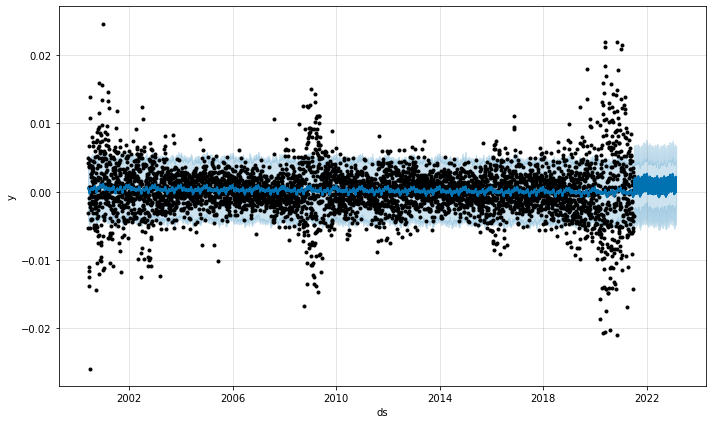

In [40]:
future = m.make_future_dataframe(periods=600)
forecast = m.predict(future)

fig1 = m.plot(forecast)


In [36]:
m.make_future_dataframe(periods=600)

,ds
0,2000-05-31
1,2000-06-01
2,2000-06-02
3,2000-06-05
4,2000-06-06
...,...
5899,2023-02-15
5900,2023-02-16
5901,2023-02-17
5902,2023-02-18


/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/qiushi/workspace/dsi-courses/APlusBernstein-Project/venv/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


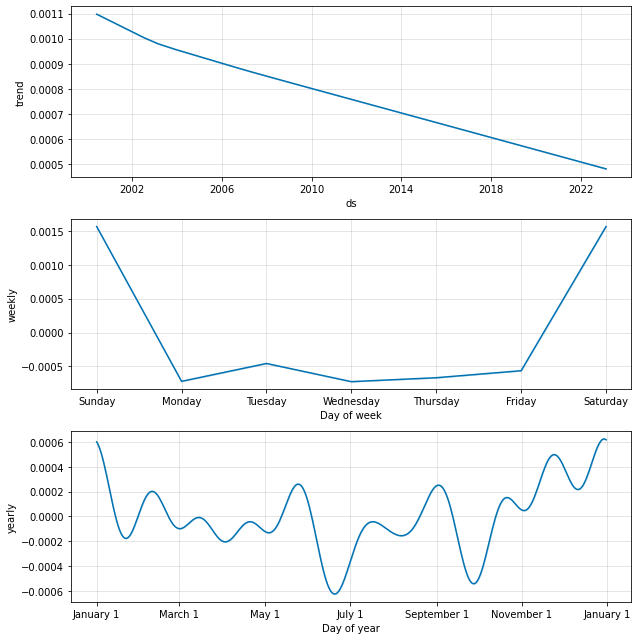

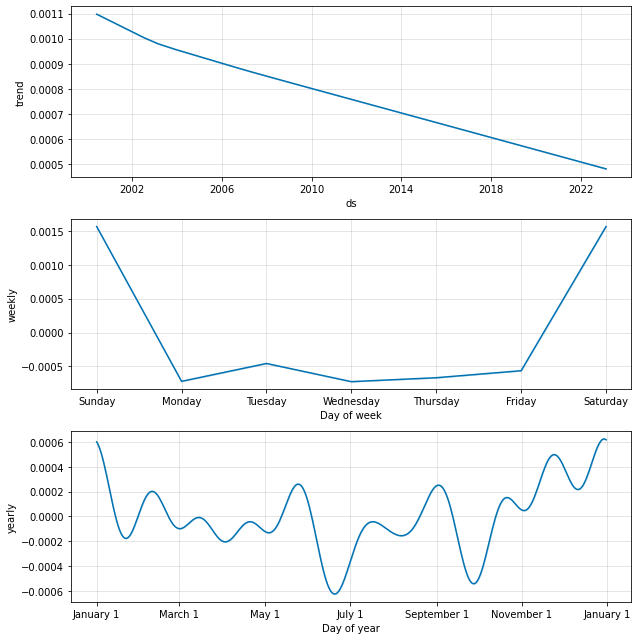

In [16]:
m.plot_components(forecast)